In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Imports

In [2]:
!pip install scikit-learn scipy matplotlib

In [3]:
import scipy

In [4]:
# Cell 5
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import itertools
import os

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data Preparation

In [5]:
# Cell 6
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = 'chest_xray'  # Change this path as needed

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.0
)

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)
val_test_gen = ImageDataGenerator(
    rescale=1./255
)

train_loader = train_gen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_loader = val_test_gen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_loader = val_test_gen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Train samples: {train_loader.samples}, Val samples: {val_loader.samples}, Test samples: {test_loader.samples}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Train samples: 5216, Val samples: 16, Test samples: 624


Baseline CNN Model

In [6]:
# Cell 7
from tensorflow.keras import layers, models

def BaselineCNN(input_shape=(128,128,3), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, 3, padding='same', activation=None, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, padding='same', activation=None),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_model = BaselineCNN()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

Dynamic CNN Architecture Builder


In [7]:
# Cell 8
def build_cnn(arch_params, input_shape=(128,128,3), num_classes=2):
    n_conv = arch_params['n_conv']
    filters = arch_params['filters']
    kernels = arch_params['kernels']
    dropout = arch_params['dropout']

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for i in range(n_conv):
        model.add(layers.Conv2D(filters[i], kernels[i], padding='same', activation=None))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.MaxPooling2D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

example_gene = {
    'n_conv': 3,
    'filters': [32, 64, 128],
    'kernels': [3, 3, 3],
    'dropout': 0.5
}
model_example = build_cnn(example_gene)
model_example.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 64)      

Training & Evaluation Functions

In [8]:
# Cell 9
def train_model(model, train_loader, val_loader, epochs=3, lr=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_loader,
        epochs=epochs,
        validation_data=val_loader,
        verbose=1
    )
    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    return train_acc_history, val_acc_history

def evaluate_model(model, loader):
    preds = model.predict(loader)
    y_true = loader.classes
    y_pred = np.argmax(preds, axis=1)
    y_probs = preds[:,1] if preds.shape[1]>1 else preds[:,0]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_probs)
    except ValueError:
        auc = 0.0
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, auc, cm

Genetic Algorithm Components

In [9]:
# Cell 10
N_CONV_RANGE = (2, 4)
FILTER_OPTIONS = [16, 32, 64, 128]
KERNEL_OPTIONS = [3, 5]
DROPOUT_RANGE = (0.3, 0.7)

def random_individual():
    n_conv = random.randint(*N_CONV_RANGE)
    filters = [random.choice(FILTER_OPTIONS) for _ in range(n_conv)]
    kernels = [random.choice(KERNEL_OPTIONS) for _ in range(n_conv)]
    dropout = round(random.uniform(*DROPOUT_RANGE), 2)
    return {
        'n_conv': n_conv,
        'filters': filters,
        'kernels': kernels,
        'dropout': dropout
    }

def initialize_population(pop_size=10):
    return [random_individual() for _ in range(pop_size)]

def fitness(individual, epochs=3):
    model = build_cnn(individual)
    _, val_acc_history = train_model(model, train_loader, val_loader, epochs=epochs, lr=0.001)
    final_val_acc = val_acc_history[-1]
    tf.keras.backend.clear_session()
    return final_val_acc

def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

def mutation(individual, mutation_rate=0.2):
    new_ind = individual.copy()
    if random.random() < mutation_rate:
        new_ind['n_conv'] = random.randint(*N_CONV_RANGE)
        new_ind['filters'] = [random.choice(FILTER_OPTIONS) for _ in range(new_ind['n_conv'])]
        new_ind['kernels'] = [random.choice(KERNEL_OPTIONS) for _ in range(new_ind['n_conv'])]
    if random.random() < mutation_rate:
        new_ind['dropout'] = round(random.uniform(*DROPOUT_RANGE), 2)
    return new_ind

def crossover(parent1, parent2):
    child = {}
    child['n_conv'] = random.choice([parent1['n_conv'], parent2['n_conv']])
    child['filters'] = (parent1['filters'] if random.random() < 0.5 else parent2['filters'])
    if len(child['filters']) < child['n_conv']:
        child['filters'] += [random.choice(FILTER_OPTIONS) for _ in range(child['n_conv']-len(child['filters']))]
    else:
        child['filters'] = child['filters'][:child['n_conv']]
    child['kernels'] = (parent1['kernels'] if random.random() < 0.5 else parent2['kernels'])
    if len(child['kernels']) < child['n_conv']:
        child['kernels'] += [random.choice(KERNEL_OPTIONS) for _ in range(child['n_conv']-len(child['kernels']))]
    else:
        child['kernels'] = child['kernels'][:child['n_conv']]
    child['dropout'] = random.choice([parent1['dropout'], parent2['dropout']])
    return child

RL Module for Operator Selection (Q-Network)

In [10]:
# Cell 11
from tensorflow.keras import layers, models, optimizers

class QNetwork(tf.keras.Model):
    def __init__(self, input_dim=3, hidden_dim=32, output_dim=2):
        super().__init__()
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc2 = layers.Dense(output_dim)
    def call(self, x):
        x = self.fc1(x)
        return self.fc2(x)

q_net = QNetwork()
target_q_net = QNetwork()
target_q_net.set_weights(q_net.get_weights())

optimizer_q = optimizers.Adam(learning_rate=0.001)
criterion_q = tf.keras.losses.MeanSquaredError()

import collections
Transition = collections.namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
replay_memory = []
MEMORY_CAPACITY = 100
BATCH_SIZE = 8
UPDATE_TARGET_EVERY = 5
update_counter = 0

def get_state(fitnesses):
    best = max(fitnesses)
    avg = sum(fitnesses)/len(fitnesses)
    std = np.std(fitnesses)
    return np.array([best, avg, std], dtype=np.float32)

def rl_select_operator(state, epsilon=0.1):
    if random.random() < epsilon:
        return random.choice([0, 1])
    state = np.expand_dims(state, axis=0)
    q_values = q_net(state)
    return int(np.argmax(q_values.numpy()))

def rl_update_batch():
    global update_counter
    if len(replay_memory) < BATCH_SIZE:
        return
    batch = random.sample(replay_memory, BATCH_SIZE)
    states = np.stack([b.state for b in batch])
    actions = np.array([b.action for b in batch])
    rewards = np.array([b.reward for b in batch])
    next_states = np.stack([b.next_state for b in batch])

    with tf.GradientTape() as tape:
        q_values = q_net(states)
        q_values = tf.gather(q_values, actions[:,None], batch_dims=1)
        next_q_values = target_q_net(next_states)
        target = rewards + 0.99 * np.max(next_q_values.numpy(), axis=1)
        loss = criterion_q(q_values, target)
    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer_q.apply_gradients(zip(grads, q_net.trainable_variables))

    update_counter += 1
    if update_counter % UPDATE_TARGET_EVERY == 0:
        target_q_net.set_weights(q_net.get_weights())

GA + RL Main Loop

In [11]:
from PIL import Image
# and then
from keras.utils import load_img

In [13]:
# Cell 12
POP_SIZE = 8
GENERATIONS = 5
EPOCHS_PER_EVAL = 2
epsilon = 0.1

population = initialize_population(POP_SIZE)
fitness_history = []
policy_reward_history = []

for gen in range(GENERATIONS):
    print(f"\nGeneration {gen+1}/{GENERATIONS}")
    fitnesses = []
    for i, individual in enumerate(population):
        print(f"Evaluating individual {i+1}/{len(population)}...")
        acc = fitness(individual, epochs=EPOCHS_PER_EVAL)
        fitnesses.append(acc)
    best_fitness = max(fitnesses)
    avg_fitness = sum(fitnesses)/len(fitnesses)
    print(f"Generation {gen+1}: Best Fitness: {best_fitness:.4f}, Average Fitness: {avg_fitness:.4f}")
    fitness_history.append(best_fitness)

    state = get_state(fitnesses)
    operator = rl_select_operator(state, epsilon=epsilon)
    operator_name = 'mutation' if operator == 0 else 'crossover'
    print("RL selected operator:", operator_name)

    new_population = []
    while len(new_population) < POP_SIZE:
        if operator == 0:
            parent = tournament_selection(population, fitnesses)
            child = mutation(parent)
        else:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
        new_population.append(child)

    new_fitnesses = []
    for i, individual in enumerate(new_population):
        acc = fitness(individual, epochs=EPOCHS_PER_EVAL)
        new_fitnesses.append(acc)
    new_best = max(new_fitnesses)
    reward = new_best - best_fitness
    policy_reward_history.append(reward)

    next_state = get_state(new_fitnesses)
    transition = Transition(state, operator, reward, next_state)
    if len(replay_memory) >= MEMORY_CAPACITY:
        replay_memory.pop(0)
    replay_memory.append(transition)

    rl_update_batch()
    population = new_population

print("GA + RL search completed.")


Generation 1/5
Evaluating individual 1/8...
Epoch 1/2
163/163 [==============================] - 24s 139ms/step - loss: 0.3089 - accuracy: 0.9047 - val_loss: 6.3244 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 23s 139ms/step - loss: 0.1330 - accuracy: 0.9456 - val_loss: 6.0694 - val_accuracy: 0.5000
Evaluating individual 2/8...
Epoch 1/2
163/163 [==============================] - 23s 138ms/step - loss: 1.7270 - accuracy: 0.8505 - val_loss: 4.6818 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 22s 136ms/step - loss: 0.2389 - accuracy: 0.9016 - val_loss: 2.6592 - val_accuracy: 0.5000
Evaluating individual 3/8...
Epoch 1/2
163/163 [==============================] - 25s 146ms/step - loss: 0.2738 - accuracy: 0.9189 - val_loss: 4.2251 - val_accuracy: 0.5000
Epoch 2/2
163/163 [==============================] - 24s 148ms/step - loss: 0.1080 - accuracy: 0.9607 - val_loss: 9.5150 - val_accuracy: 0.5000
Evaluating individual 4/8...
Epoc

13. Final Evaluation and Detailed Metrics


In [14]:
# Cell 13
final_fitnesses = []
for individual in population:
    print("Extended training evaluation of one individual...")
    acc = fitness(individual, epochs=5)
    final_fitnesses.append(acc)

best_idx = np.argmax(final_fitnesses)
best_individual = population[best_idx]
print("Best individual gene:", best_individual)

final_model = build_cnn(best_individual)
print("Training the final model for extended epochs...")
train_model(final_model, train_loader, val_loader, epochs=10, lr=0.001)
accuracy, precision, recall, f1, auc, cm = evaluate_model(final_model, test_loader)

print("\nFinal Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)

Extended training evaluation of one individual...
Epoch 1/5
163/163 [==============================] - 24s 146ms/step - loss: 0.3440 - accuracy: 0.9155 - val_loss: 7.4212 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 24s 144ms/step - loss: 0.1154 - accuracy: 0.9557 - val_loss: 4.8069 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 23s 139ms/step - loss: 0.1064 - accuracy: 0.9617 - val_loss: 0.8227 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 23s 140ms/step - loss: 0.0936 - accuracy: 0.9622 - val_loss: 0.6248 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 23s 139ms/step - loss: 0.0801 - accuracy: 0.9712 - val_loss: 0.4218 - val_accuracy: 0.8125
Extended training evaluation of one individual...
Epoch 1/5
163/163 [==============================] - 23s 140ms/step - loss: 0.5036 - accuracy: 0.8783 - val_loss: 5.7051 - val_accuracy: 0.5000
Epoch 2/5
163/163 [=================

14. Save the final model

In [15]:
# Cell 14
model_path = "final_model.h5"
final_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to final_model.h5


15. Load the saved model

In [16]:
# Cell 15
from tensorflow.keras.models import load_model
final_model = load_model(model_path)
print("Model loaded and ready for inference.")

Model loaded and ready for inference.


16. Visualizations

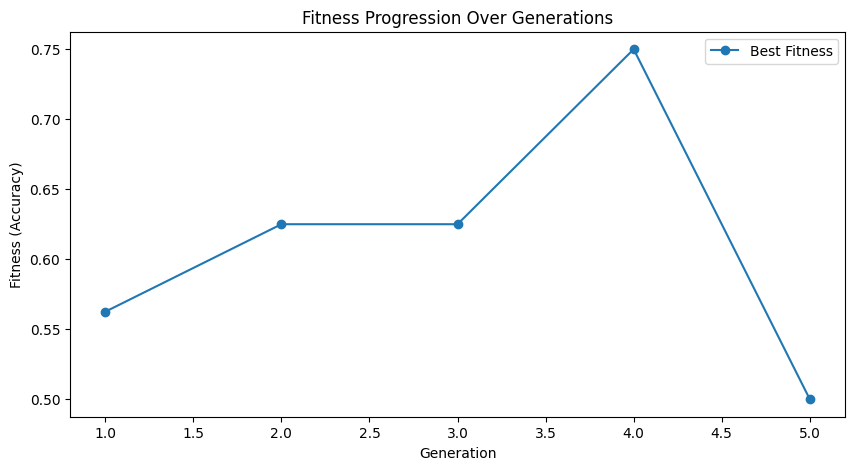

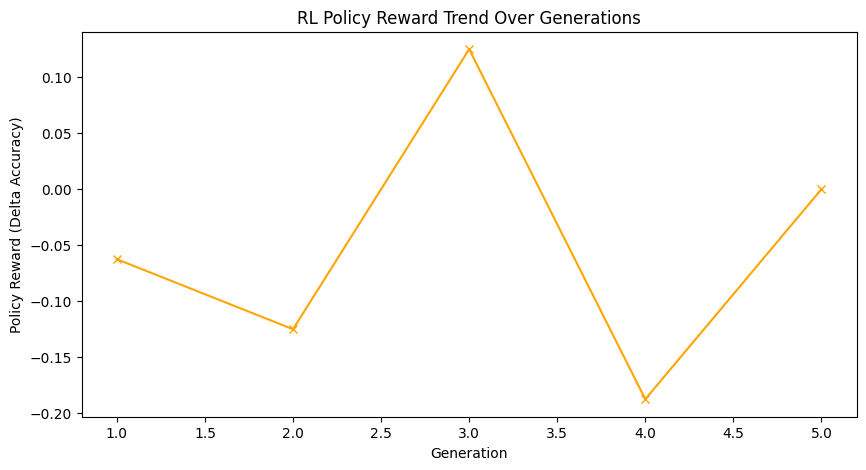

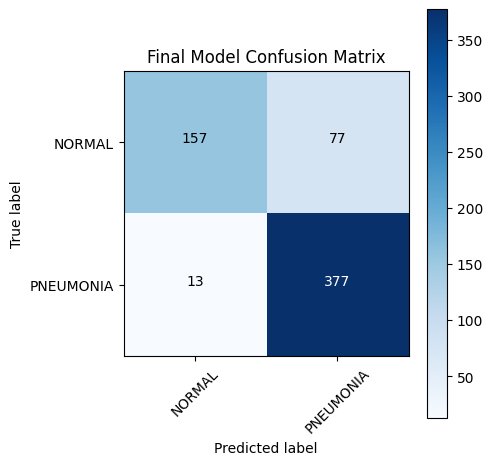

In [17]:
# Cell 16
plt.figure(figsize=(10, 5))
plt.plot(range(1, GENERATIONS+1), fitness_history, marker='o', label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("Fitness Progression Over Generations")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, GENERATIONS+1), policy_reward_history, marker='x', color='orange')
plt.xlabel("Generation")
plt.ylabel("Policy Reward (Delta Accuracy)")
plt.title("RL Policy Reward Trend Over Generations")
plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=list(train_loader.class_indices.keys()), title="Final Model Confusion Matrix")
plt.show()

17. Testing on a Single Image

In [19]:
# Cell 17
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np

image_path = "IM-0009-0001.jpeg"  # Replace with your actual image path

img = keras_image.load_img(image_path, target_size=(128, 128))
img_array = keras_image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

final_model.eval = lambda: None  # For compatibility with PyTorch code
probs = final_model.predict(img_array)
prob_pneumonia = probs[0, 1]
prediction = 1 if prob_pneumonia >= 0.5 else 0

print(f"Prediction: {'Pneumonia' if prediction == 1 else 'Normal'} (Probability: {prob_pneumonia:.4f})")

1/1 [==============================] - 0s 202ms/step
Prediction: Normal (Probability: 0.0794)


18. Grad-CAM Implementation

In [24]:
# Cell 18
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from PIL import Image

def grad_cam(model, img_array, target_class, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, target_class]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.5, colormap=plt.cm.jet):
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(img.size)
    heatmap = np.array(heatmap)
    heatmap = colormap(heatmap)
    heatmap = np.uint8(heatmap * 255)
    overlayed = Image.blend(img.convert('RGB'), Image.fromarray(heatmap[..., :3]), alpha)
    return overlayed

19. Grad-CAM Visualization Example

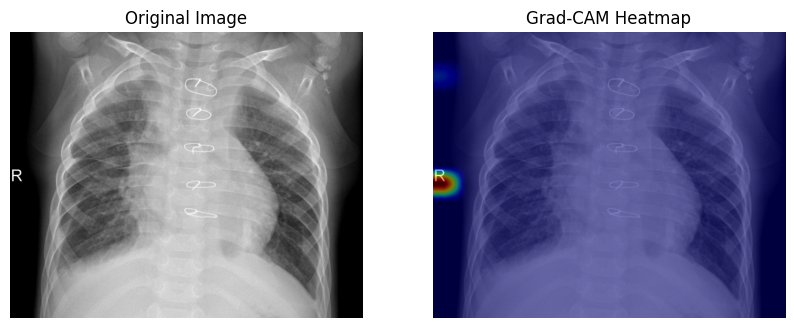

In [29]:
# Cell 19
image_path = "person3_bacteria_12.jpeg"  # Replace with your actual image path
raw_image = Image.open(image_path).convert('RGB')
img = keras_image.load_img(image_path, target_size=(128, 128))
img_array = keras_image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

target_class = 1  # Pneumonia class index
layer_name = [layer.name for layer in final_model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
heatmap = grad_cam(final_model, img_array, target_class, layer_name)
overlayed_image = overlay_heatmap(raw_image, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(raw_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

Print Final Model

In [ ]:
# Cell 20
final_model.summary()